# About Us

Our team consists of the following members, with their contributions listed:
  - Wenbo Zhang ([Falanan](https://github.com/Falanan)) - 100778036
    - Initial code & analysis
    - Code for data download
    - DataLoader code
    - ResNet Trainer & VGG Trainer code
    - ResNet18 & ResNet50 & VGG11 & VGG16 fine tuning code
  - Martin Truong ([martru118](https://github.com/martru118)) - 100708410
    - VGG models and Trainer
    - Code refactor
    - Plotting
    - Presentation
  - Wyatt Ritchie ([wyattRitchie](https://github.com/wyattRitchie)) - 100483764
    - Image pre processing
    - Presentation

# About Dataset

This dataset is a dataset on dog breed classification. 

The dataset comes from Stanford University. ([Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/))

In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import warnings
warnings.filterwarnings("ignore")

import torch
from torch import (nn, optim)
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import itertools
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2 as cv
import scipy.io
import re

from PIL import Image
import time
import random

print("PyTorch version:", torch.__version__)
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if getattr(torch,'has_mps',False) else "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
# device = "cpu"
devices = [torch.device(f'cuda:{i}')
            for i in range(torch.cuda.device_count())]

PyTorch version: 2.0.0+cu118
Using cuda device


# Pre-processing of images

We download the dataset and split it into training images and test images. The dataset is split based on the file list.

In [2]:
! wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

--2023-04-16 06:10:34--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  56.0MB/s    in 14s     

2023-04-16 06:10:48 (52.6 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [3]:
! wget http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar

--2023-04-16 06:10:49--  http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 481280 (470K) [application/x-tar]
Saving to: ‘lists.tar’

lists.tar           100%[===================>] 470.00K  1.21MB/s    in 0.4s    

2023-04-16 06:10:49 (1.21 MB/s) - ‘lists.tar’ saved [481280/481280]



In [4]:
! tar -xvf images.tar | wc

  20701   20701 1035199


In [5]:
! tar -xvf lists.tar | wc

      3       3      43


In [6]:
! ls

file_list.mat  images.tar  sample_data	  train_list.mat
Images	       lists.tar   test_list.mat


In [7]:
# load training data
train_data_list = scipy.io.loadmat('train_list.mat')

# get file names
train_data_file_name_list = [inner_list[0] for inner_list in train_data_list["file_list"]]
train_data_file_name_list = [inner_list[0] for inner_list in train_data_file_name_list]

# get breeds
pattern = r'-(.*?)/'
train_data_breeds_list = [[re.search(pattern, item[0]).group(1) for item in sublist] for sublist in train_data_list["file_list"].tolist()]
train_data_breeds_list = [inner_list[0] for inner_list in train_data_breeds_list]

# get labels
train_data_labels = train_data_list["labels"].tolist()
train_data_labels = [label[0]-1 for label in train_data_labels]

# get paths of images
train_data_file_path_list = ["Images/"+inner_list for inner_list in train_data_file_name_list]

In [13]:
train_data_df = pd.DataFrame({"File_Name": train_data_file_name_list, "File_Path": train_data_file_path_list, "Breed":train_data_breeds_list, "Breed_Label": train_data_labels})
train_data_df.head()

,File_Name,File_Path,Breed,Breed_Label
0,n02085620-Chihuahua/n02085620_5927.jpg,Images/n02085620-Chihuahua/n02085620_5927.jpg,Chihuahua,0
1,n02085620-Chihuahua/n02085620_4441.jpg,Images/n02085620-Chihuahua/n02085620_4441.jpg,Chihuahua,0
2,n02085620-Chihuahua/n02085620_1502.jpg,Images/n02085620-Chihuahua/n02085620_1502.jpg,Chihuahua,0
3,n02085620-Chihuahua/n02085620_1916.jpg,Images/n02085620-Chihuahua/n02085620_1916.jpg,Chihuahua,0
4,n02085620-Chihuahua/n02085620_13151.jpg,Images/n02085620-Chihuahua/n02085620_13151.jpg,Chihuahua,0


In [14]:
print("Training dataframe has a shape of:", train_data_df.shape)

Training dataframe has a shape of: (12000, 4)


In [9]:
# load test data
test_data_list = scipy.io.loadmat('test_list.mat')

test_data_file_name_list = [inner_list[0] for inner_list in test_data_list["file_list"]]
test_data_file_name_list = [inner_list[0] for inner_list in test_data_file_name_list]

pattern = r'-(.*?)/'
test_data_breeds_list = [[re.search(pattern, item[0]).group(1) for item in sublist] for sublist in test_data_list["file_list"].tolist()]
test_data_breeds_list = [inner_list[0] for inner_list in test_data_breeds_list]

test_data_labels = test_data_list["labels"].tolist()
test_data_labels = [label[0]-1 for label in test_data_labels]

test_data_file_path_list = ["Images/"+inner_list for inner_list in test_data_file_name_list]

In [11]:
test_data_df = pd.DataFrame({"File_Name": test_data_file_name_list, "File_Path": test_data_file_path_list, "Breed":test_data_breeds_list, "Breed_Label": test_data_labels})
test_data_df.head()

,File_Name,File_Path,Breed,Breed_Label
0,n02085620-Chihuahua/n02085620_2650.jpg,Images/n02085620-Chihuahua/n02085620_2650.jpg,Chihuahua,0
1,n02085620-Chihuahua/n02085620_4919.jpg,Images/n02085620-Chihuahua/n02085620_4919.jpg,Chihuahua,0
2,n02085620-Chihuahua/n02085620_1765.jpg,Images/n02085620-Chihuahua/n02085620_1765.jpg,Chihuahua,0
3,n02085620-Chihuahua/n02085620_3006.jpg,Images/n02085620-Chihuahua/n02085620_3006.jpg,Chihuahua,0
4,n02085620-Chihuahua/n02085620_1492.jpg,Images/n02085620-Chihuahua/n02085620_1492.jpg,Chihuahua,0


In [12]:
print("Test dataframe has a shape of:",test_data_df.shape)

Test dataframe has a shape of: (8580, 4)


Save the list of breeds and their labels.

In [21]:
! mkdir records

In [ ]:
# map breeds to label
breeds = test_data_df[['Breed_Label', 'Breed']].drop_duplicates()

In [ ]:
# write breeds to file
breeds_data = breeds.to_csv(index=False)
with open('records/breeds_data.csv', 'w') as f:
    f.write(breeds_data)

Below is a short sample of images in the dataset. From this sample we can see that there is very little consistency in the images, both in terms of subject and of quality. 

In [15]:
img = cv.imread(train_data_file_path_list[0])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

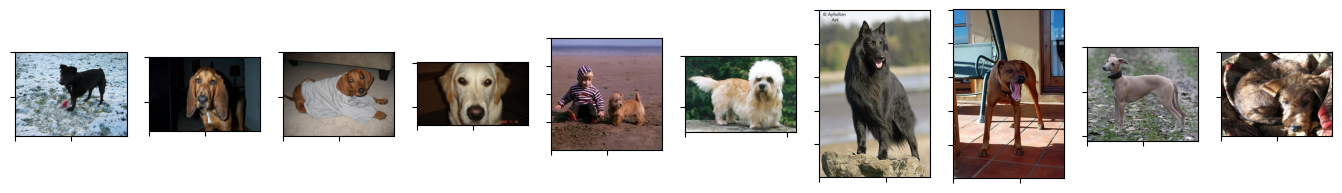

In [16]:
# get random images from the dataset
random_sample = [random.randint(1, 8000) for _ in range(10)]
fig, axs = plt.subplots(1, 10, figsize=(17,17))

for i, ax in enumerate(axs):
    img = cv.imread(train_data_file_path_list[random_sample[i]])
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, labelright=False, labeltop=False)

plt.show()

Below is an example of image pre-processing done on the dataset.

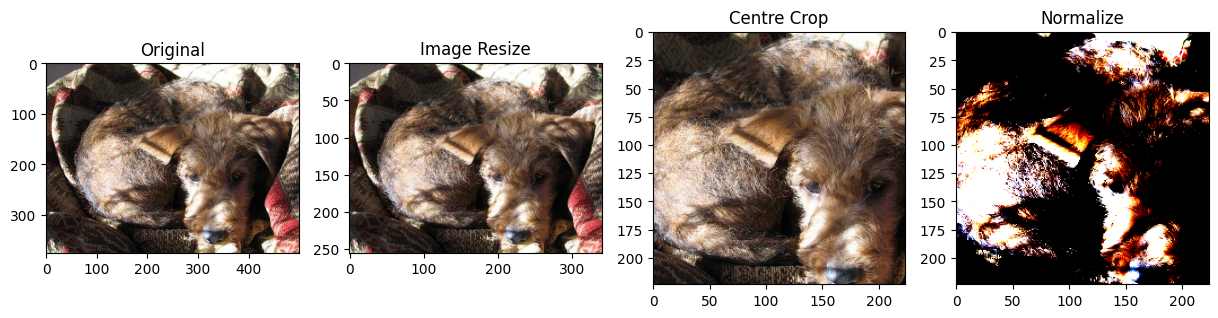

In [17]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Resize(256)])
trans2 = transforms.Compose([transforms.CenterCrop(224)])
trans3 = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

img1_trans1 = trans(img)
img1_trans2 = trans2(img1_trans1)
img1_trans3 = trans3(img1_trans2)
img1_trans1 = np.transpose(img1_trans1, (1, 2, 0))
img1_trans2 = np.transpose(img1_trans2, (1, 2, 0))
img1_trans3 = np.transpose(img1_trans3, (1, 2, 0))
fig, axs = plt.subplots(1, 4, figsize=(15,15))
axs[0].imshow(img)
axs[1].imshow(img1_trans1)
axs[2].imshow(img1_trans2)
axs[3].imshow(img1_trans3)

axs[0].set_title('Original')
axs[1].set_title('Image Resize')
axs[2].set_title('Centre Crop')
axs[3].set_title('Normalize')
plt.show()

With the data pre-processed, we create our dataset.

In [18]:
class DogsDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['File_Path']
        breed_label = self.dataframe.iloc[idx]['Breed_Label']
        img = Image.open(img_path)
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, breed_label

# transform the data
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [19]:
# create training and test datasets
dogs_dataset = DogsDataset(train_data_df, transform=data_transforms)
train_dataset, val_dataset = random_split(dogs_dataset, (0.8, 0.2))

# get shape of datasets
train_dataloader_for_display = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader_for_display = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [20]:
for xs, ys in train_dataloader_for_display:
    break
xs.shape, ys.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

# Evaluating our models

We create a function that evaluates a model using `test_dataset.npz`.

In [22]:
! mkdir models

In [48]:
def test_model(model = None, saved_model = None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_dog_dataset = DogsDataset(test_data_df, transform=data_transforms)

    if saved_model != None:
        #print("Loading from saved model.")
        model = torch.load(saved_model).to(device)
    elif model != None:
        model.to(device)

    loss = nn.CrossEntropyLoss()
    dataloader = DataLoader(test_dog_dataset, batch_size=128, shuffle=True)

    accuracy = 0

    with torch.no_grad():
        for xs, targets in dataloader:
            xs, targets = xs.to(device), targets.to(device)
            ys = model(xs)
            accuracy += (ys.argmax(axis=1) == targets).sum().item()

    #print("Saved model has test accuracy = %.4f" % acc)
    accuracy = accuracy / len(test_dog_dataset) * 100
    return accuracy

In [24]:
epochs = 6

# Apply ResNet models

Here, we will apply ResNet model (`resnet18` and `resnet50`) for transfer learning and create a trainer class for the model.

In [25]:
# trainer for resnet model
class ResNet_Trainer:
    def __init__(self, model, train_dataset, val_dataset, learning_rate, batch_size, param_group=True):
        self.model = model
        self.train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.val_dataloader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=True)
        self.loss = nn.CrossEntropyLoss()

        if param_group:
            # fine-tune model
            params_1x = [param for name, param in model.named_parameters()
                if name not in ["fc.weight", "fc.bias"]]
            self.optimizer = torch.optim.Adam([{'params': params_1x},
                                    {'params': model.fc.parameters(),
                                        'lr': learning_rate * 10}],
                                    lr=learning_rate, weight_decay=0.00001)
        else:
            self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                    weight_decay=0.00001)
            

    def categorical_accuracy(self, y_out, y_true):
      # calculate accuracy
      pred = y_out.argmax(axis=1)
      success = (pred == y_true).sum().item()
      total = len(y_true)
      return success / total
        
    def train_one_epoch(self):
        self.model.train()
        l_list = []
        acc_list = []
        for (i, (xs, targets)) in enumerate(self.train_dataloader):
            xs, targets = xs.to(device), targets.to(device)

            # calculate loss
            self.optimizer.zero_grad()
            opt = self.model(xs)
            loss = self.loss(opt, targets)
            loss.backward()
            self.optimizer.step()

            # log loss and accuracy
            l_list.append(loss.item())
            acc_list.append(self.categorical_accuracy(opt, targets))

        return np.mean(l_list), np.mean(acc_list)
    
    def val_one_epoch(self):
        self.model.eval()
        l_list = []
        acc_list = []
        with torch.no_grad():
            for (xs, targets) in self.val_dataloader:
                xs, targets = xs.to(device), targets.to(device)
                opt = self.model(xs)
                loss = self.loss(opt, targets)

                # log loss and accuracy
                l_list.append(loss.item())
                acc_list.append(self.categorical_accuracy(opt, targets))

        return np.mean(l_list), np.mean(acc_list)
                
    def train(self, epochs):
        history = {
            'train_loss': [],
            'train_accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
            'epoch_duration': [],
        }

        start0 = time.time()

        for epoch in range(epochs):
            start = time.time()
            train_loss, train_acc = self.train_one_epoch()
            val_loss, val_acc = self.val_one_epoch()

            duration = time.time() - start
            history['train_loss'].append(train_loss)
            history['train_accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)
            history['epoch_duration'].append(duration)
            
            print("[%d (%.4fs)]: train_loss=%.4f train_acc=%.4f, val_loss=%.4f val_acc=%.4f" % (epoch+1, duration, train_loss, train_acc, val_loss, val_acc))
            
        duration0 = time.time() - start0
        print("== Total training time %.4f seconds ==" % duration0)
        return pd.DataFrame(history)

In [26]:
resnet18_model = torchvision.models.resnet18(pretrained=True)
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features,120)    # change to 120 labels
resnet18_model = resnet18_model.to(device)
resnet18trainer = ResNet_Trainer(resnet18_model, train_dataset, val_dataset, 5e-5,128)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


In [27]:
# train model
resnet18_log = resnet18trainer.train(epochs)

[1 (116.7618s)]: train_loss=3.1977 train_acc=0.3707, val_loss=1.7912 val_acc=0.6651
[2 (112.5373s)]: train_loss=1.2983 train_acc=0.7546, val_loss=1.1403 val_acc=0.7395
[3 (110.0501s)]: train_loss=0.7498 train_acc=0.8606, val_loss=0.8885 val_acc=0.7715
[4 (109.4918s)]: train_loss=0.4584 train_acc=0.9257, val_loss=0.8229 val_acc=0.7712
[5 (110.6676s)]: train_loss=0.2780 train_acc=0.9696, val_loss=0.7666 val_acc=0.7858
[6 (109.7251s)]: train_loss=0.1687 train_acc=0.9892, val_loss=0.7392 val_acc=0.7895
== Total training time 669.2391 seconds ==


In [28]:
resnet18_csv_data = resnet18_log.to_csv(index=False)
with open('records/resnet18_csv_data.csv', 'w') as f:
    f.write(resnet18_csv_data)

In [29]:
resnet18_model = resnet18_model.to("cpu")
torch.save(resnet18_model, 'models/resnet18_model.pt')
torch.cuda.empty_cache()

Fine-tune and train a different model. This time, we are using ResNet50.

In [30]:
resnet50_model = torchvision.models.resnet50(pretrained=True)
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features,120)    # change to 120 labels
resnet50_model = resnet50_model.to(device)
resnet50trainer = ResNet_Trainer(resnet50_model, train_dataset, val_dataset, 5e-5, 128)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 108MB/s]


In [31]:
# train model
resnet50_log = resnet50trainer.train(epochs)

[1 (178.1292s)]: train_loss=2.1301 train_acc=0.5942, val_loss=0.7935 val_acc=0.8158
[2 (179.3901s)]: train_loss=0.4763 train_acc=0.8831, val_loss=0.5481 val_acc=0.8496
[3 (179.2760s)]: train_loss=0.1975 train_acc=0.9579, val_loss=0.4886 val_acc=0.8487
[4 (178.7121s)]: train_loss=0.0819 train_acc=0.9879, val_loss=0.4601 val_acc=0.8583
[5 (179.2338s)]: train_loss=0.0382 train_acc=0.9964, val_loss=0.4593 val_acc=0.8637
[6 (178.5510s)]: train_loss=0.0204 train_acc=0.9988, val_loss=0.4662 val_acc=0.8618
== Total training time 1073.2975 seconds ==


In [32]:
resnet50_csv_data = resnet50_log.to_csv(index=False)
with open('records/resnet50_csv_data.csv', 'w') as f:
    f.write(resnet50_csv_data)

In [33]:
resnet50_model = resnet50_model.to("cpu")
torch.save(resnet50_model, 'models/resnet50_model.pt')
torch.cuda.empty_cache()

# Apply VGG models

Here, we will apply VGG model (`VGG16` and `VGG11`) for transfer learning and create a trainer class for the model.

In [34]:
# trainer for vgg model
class VGG_Trainer:
    def __init__(self, model, train_dataset, val_dataset, learning_rate, batch_size, param_group=True):
        self.model = model
        self.train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.val_dataloader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=True)
        self.loss = nn.CrossEntropyLoss()

        if param_group:
            # fine-tune model
            params_1x = [param for name, param in model.named_parameters()
                if name not in ["classifier.6.weight", "classifier.6.bias"]]
            self.optimizer = torch.optim.Adam([{'params': params_1x},
                                    {'params': model.classifier[6].parameters(),
                                        'lr': learning_rate * 10}],
                                    lr=learning_rate, weight_decay=0.00001)
        else:
            self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00001)

    def categorical_accuracy(self, y_out, y_true):
      # calculate accuracy
      pred = y_out.argmax(axis=1)
      success = (pred == y_true).sum().item()
      total = len(y_true)
      return success / total
        
    def train_one_epoch(self):
        self.model.train()
        l_list = []
        acc_list = []
        for (i, (xs, targets)) in enumerate(self.train_dataloader):
            xs, targets = xs.to(device), targets.to(device)

            # calculate loss
            self.optimizer.zero_grad()
            opt = self.model(xs)
            loss = self.loss(opt, targets)
            loss.backward()
            self.optimizer.step()

            # log loss and accuracy
            l_list.append(loss.item())
            acc_list.append(self.categorical_accuracy(opt, targets))

        return np.mean(l_list), np.mean(acc_list)
    
    def val_one_epoch(self):
        self.model.eval()
        l_list = []
        acc_list = []

        with torch.no_grad():
            for (xs, targets) in self.val_dataloader:
                xs, targets = xs.to(device), targets.to(device)
                opt = self.model(xs)
                loss = self.loss(opt, targets)

                # log loss and accuracy
                l_list.append(loss.item())
                acc_list.append(self.categorical_accuracy(opt, targets))

        return np.mean(l_list), np.mean(acc_list)
                
    def train(self, epochs):
        history = {
            'train_loss': [],
            'train_accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
            'epoch_duration': [],
        }

        start0 = time.time()

        for epoch in range(epochs):
            start = time.time()
            train_loss, train_acc = self.train_one_epoch()
            val_loss, val_acc = self.val_one_epoch()

            duration = time.time() - start
            history['train_loss'].append(train_loss)
            history['train_accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)
            history['epoch_duration'].append(duration)
            
            print("[%d (%.4fs)]: train_loss=%.4f train_acc=%.4f, val_loss=%.4f val_acc=%.4f" % (epoch+1, duration, train_loss, train_acc, val_loss, val_acc))
            
        duration0 = time.time() - start0
        print("== Total training time %.4f seconds ==" % duration0)

        return pd.DataFrame(history)

In [35]:
vgg16_model = torchvision.models.vgg16(pretrained=True)

# change classifier to 120 categories of dogs
vgg16_model.classifier[6] = nn.Linear(vgg16_model.classifier[6].in_features, 120)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 216MB/s]


In [36]:
# train model
vgg16_model = vgg16_model.to(device)
vgg16_trainer = VGG_Trainer(vgg16_model, train_dataset, val_dataset, 5e-5, 64)
vgg16_log = vgg16_trainer.train(epochs)

[1 (228.1726s)]: train_loss=1.4506 train_acc=0.6059, val_loss=0.6936 val_acc=0.7863
[2 (227.6527s)]: train_loss=0.5095 train_acc=0.8358, val_loss=0.6828 val_acc=0.7867
[3 (228.2055s)]: train_loss=0.2872 train_acc=0.9038, val_loss=0.7121 val_acc=0.7858
[4 (228.2102s)]: train_loss=0.1825 train_acc=0.9402, val_loss=0.8456 val_acc=0.7585
[5 (226.7153s)]: train_loss=0.1378 train_acc=0.9551, val_loss=0.8479 val_acc=0.7777
[6 (228.2807s)]: train_loss=0.1013 train_acc=0.9648, val_loss=0.8041 val_acc=0.7799
== Total training time 1367.2402 seconds ==


In [37]:
vgg16_csv_data = vgg16_log.to_csv(index=False)
with open('records/vgg16_csv_data.csv', 'w') as f:
    f.write(vgg16_csv_data)

In [38]:
vgg16_model = vgg16_model.to("cpu")
torch.save(vgg16_model, 'models/vgg16_model.pt')
torch.cuda.empty_cache()

Fine-tune and train a different model. This time, we are using VGG11.

In [39]:
vgg11_model = torchvision.models.vgg11(pretrained=True)

# change classifier to 120 categories of dogs
vgg11_model.classifier[6] = nn.Linear(vgg11_model.classifier[6].in_features, 120)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:13<00:00, 38.1MB/s]


In [40]:
# train model
vgg11_model = vgg11_model.to(device)
vgg11_trainer = VGG_Trainer(vgg11_model, train_dataset, val_dataset, 5e-5, 64)
vgg11_log = vgg11_trainer.train(epochs)

[1 (156.2669s)]: train_loss=1.6267 train_acc=0.5566, val_loss=0.8424 val_acc=0.7508
[2 (156.7959s)]: train_loss=0.6028 train_acc=0.8052, val_loss=0.7919 val_acc=0.7607
[3 (156.1768s)]: train_loss=0.2997 train_acc=0.8991, val_loss=0.7921 val_acc=0.7595
[4 (155.6686s)]: train_loss=0.1827 train_acc=0.9358, val_loss=0.9015 val_acc=0.7375
[5 (156.2055s)]: train_loss=0.1320 train_acc=0.9566, val_loss=0.9846 val_acc=0.7386
[6 (156.2990s)]: train_loss=0.0866 train_acc=0.9717, val_loss=1.0465 val_acc=0.7342
== Total training time 937.4153 seconds ==


In [41]:
vgg11_csv_data = vgg11_log.to_csv(index=False)
with open('records/vgg11_csv_data.csv', 'w') as f:
    f.write(vgg11_csv_data)

In [42]:
vgg11_model = vgg11_model.to("cpu")
torch.save(vgg11_model, 'models/vgg11_model.pt')
torch.cuda.empty_cache()

Now that we have the records and models for both networks, we save the outputs to a zip file.

In [43]:
! zip -r records.zip records

  adding: records/ (stored 0%)
  adding: records/vgg16_csv_data.csv (deflated 47%)
  adding: records/vgg11_csv_data.csv (deflated 47%)
  adding: records/resnet50_csv_data.csv (deflated 50%)
  adding: records/resnet18_csv_data.csv (deflated 48%)


In [44]:
! zip -r models.zip models

  adding: models/ (stored 0%)
  adding: models/resnet50_model.pt (deflated 7%)
  adding: models/vgg11_model.pt (deflated 7%)
  adding: models/vgg16_model.pt (deflated 7%)
  adding: models/resnet18_model.pt (deflated 7%)


# Plot training accuracy

We plot the training accuracies between the fine-tuned ResNet and VGG models.

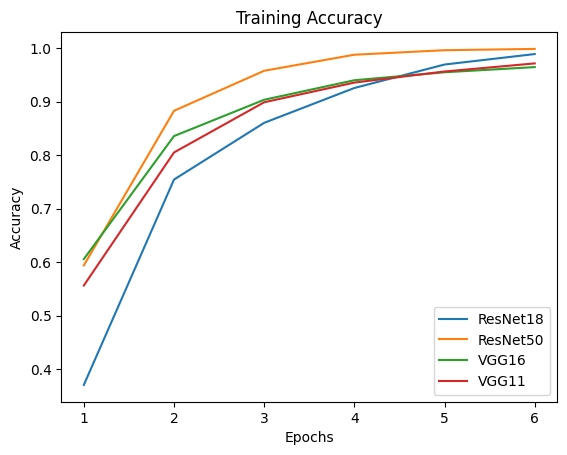

In [45]:
plt.figure()
plt.plot(resnet18_log.index+1, resnet18_log.train_accuracy)
plt.plot(resnet50_log.index+1, resnet50_log.train_accuracy)
plt.plot(vgg16_log.index+1, vgg16_log.train_accuracy)
plt.plot(vgg11_log.index+1, vgg11_log.train_accuracy)

plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['ResNet18', 'ResNet50', 'VGG16', 'VGG11']);

# Plot test accuracy

Test the fine-tuned ResNet and VGG models and plot the test accuracy (in a bar plot).

In [49]:
resnet50_test_acc = test_model(model = resnet50_model)
resnet18_test_acc = test_model(model = resnet18_model)
vgg16_test_acc = test_model(model = vgg16_model)
vgg11_test_acc = test_model(model = vgg11_model)

print("ResNet18 model test accuracy: %.4f" % resnet18_test_acc)
print("ResNet50 model test accuracy: %.4f" % resnet50_test_acc)
print("VGG11 model test accuracy: %.4f" % vgg16_test_acc)
print("VGG16 model test accuracy: %.4f" % vgg16_test_acc)

ResNet18 model test accuracy: 78.6014
ResNet50 model test accuracy: 85.8275
VGG11 model test accuracy: 77.2611
VGG16 model test accuracy: 77.2611


Text(0.5, 1.0, 'Comparison of Test Accuracies')

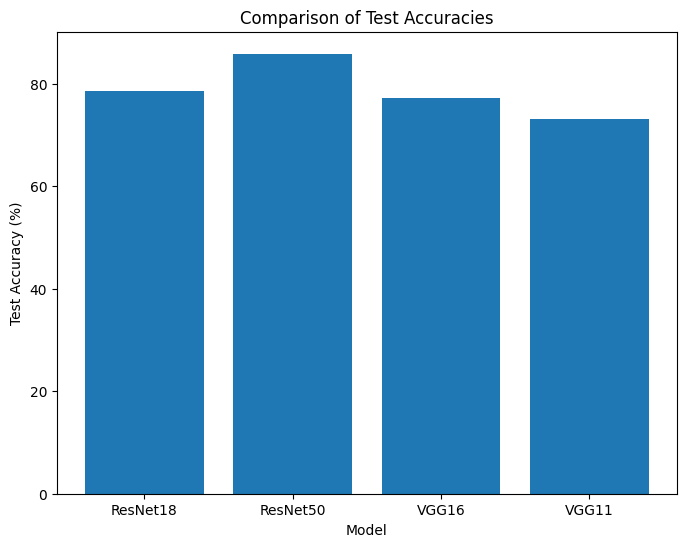

In [50]:
test_accs = [resnet18_test_acc, resnet50_test_acc, vgg16_test_acc, vgg11_test_acc]
model_names = ['ResNet18', 'ResNet50', 'VGG16', 'VGG11']

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(model_names, test_accs)

ax.set_xlabel('Model')
ax.set_ylabel('Test Accuracy (%)')
ax.set_title('Comparison of Test Accuracies')